# Lesson6 ニューラルネットに画像を生成させよう

## 目次

- Section1 Checkクイズの解答
- Section2 実装①
  - 2.1 FashionMNISTを用いたGAN

## Section1 Checkクイズの解答
問題1: 2, 問題2: 3

In [1]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test


def plot_mnist(n_ex=10,dim=(2,5), figsize=(8,4)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Section2 実装①

### 2.1 FashionMNISTを用いたGAN

このSectionでは、Section1で行ったGANによる学習をFashionMNISTの画像にも適用させて、ニューラルネットにファッション画像が生成出来るように学習させてみましょう。

### 2.1.1 GANのモデルの作成

In [2]:
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Flatten, Activation, LeakyReLU, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tqdm import tqdm

def Generator():
    nch=200
    model_input = Input(shape=[100])
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='glorot_uniform')(x)
    model_output = Activation('sigmoid')(x)
    model = Model(model_input, model_output)
    
    return model


def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    model_input = Input(shape=shape)
    x = Conv2D(256, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(model_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', kernel_initializer='glorot_uniform', strides=(2, 2))(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x)
    model = Model(model_input, model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    
    return model


def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[100])
    x = generator(gan_input)
    gan_output = discriminator(x)
    model = Model(gan_input, gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    
    return model


def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

        
def train(step=10000, BATCH_SIZE=128):
    for e in tqdm(range(step)):  
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        make_trainable(discriminator,True)
        
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        discriminator.train_on_batch(X,y)
        
        make_trainable(discriminator,False)
    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
             
        GAN.train_on_batch(noise_gen, y2 )

### 2.1.2 FashionMNISTによる学習

In [4]:
X_train, _,_,_ = load_mnist(data='fashion')
generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

train(1000)


100%|██████████| 1000/1000 [03:50<00:00,  4.33it/s]


### 2.1.3 画像の生成

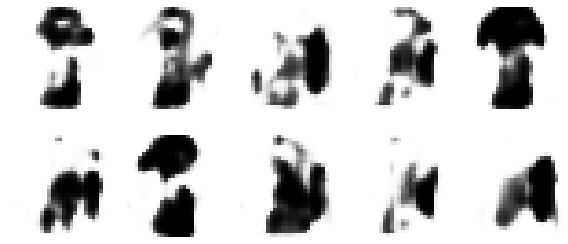

In [5]:
plot_mnist()

## Check実装

- 課題
    - 学習のステップの応じて生成される画像がどのように変わっていくか確かめてみましょう

In [7]:
train(2000)


100%|██████████| 2000/2000 [07:46<00:00,  4.29it/s]


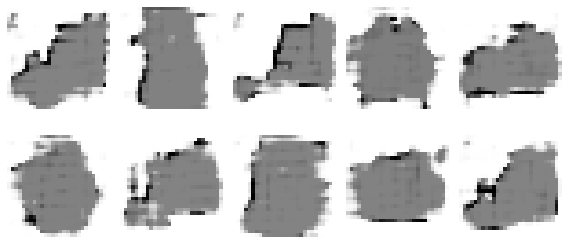

In [8]:
plot_mnist()